<h1>Analysis of Preprint Papers from the ArXiv</h1>

The website https://arxiv.org is a popular database for scientific papers in STEM fields. ArXiv has its own classification system consisting of roughly 150 different categories, which are manually added by the authors whenever a new paper is uploaded. A paper can be assigned multiple categories.

The goal for this project is to develop a machine learning model which can predict the ArXiv category from a given title and abstract. The data set used here has been scraped from the ArXiv API, see https://arxiv.org/help/api, using a Python scraper which can be downloaded from

<p><center><a href=https://github.com/saattrupdan/scholarly/blob/master/arxiv_scraper.py>https://github.com/saattrupdan/scholarly/blob/master/arxiv_scraper.py.</a>.</center></p>

<h2> Fetching data </h2>

We start by importing all the packages we will need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

Next, we download the data set. This can of course be replaced by any other data set obtained from the above-mentioned ArXiv scraper. I have included two data sets:

<ul>
    <li> The <tt>arxiv.csv</tt> file is the entire data set. This data set is very large (~1.2gb) and includes at most 10,000 papers from every ArXiv category.</li>
    <li> The <tt>arxiv_small.csv</tt> file is more manageable (~200mb) and includes at most 1,000 papers from every ArXiv category.</li>
</ul>

In [2]:
# download the large data set
#!wget -O arxiv.csv https://filedn.com/lRBwPhPxgV74tO0rDoe8SpH/arxiv.csv

# download the small data set
#!wget -O arxiv_small.csv https://filedn.com/lRBwPhPxgV74tO0rDoe8SpH/arxiv_small.csv

# download categories as csv
#!wget -O cats.csv https://filedn.com/lRBwPhPxgV74tO0rDoe8SpH/cats.csv

In [3]:
# load list of categories
cats = list(pd.read_csv("cats.csv")['category'].values)

def nan_if_empty(x):
    if len(x) == 0:
        return np.nan
    else:
        return x

def remove_non_cats(x):
    return list(filter(lambda y: y in cats, x))

def str_to_list(x):
    return x[1:-1].replace('\'','').split(',')

def clean_cats(x):
    return nan_if_empty(remove_non_cats(str_to_list(x)))

In [4]:
# choose the large or small data set
#file_name = 'arxiv.csv'
file_name = 'arxiv_small.csv'

# set up dataframe, which also converts the category variable from a string to a list
df = pd.read_csv(file_name, converters={'category': clean_cats})[['title', 'abstract', 'category']]

df = df[:100]

print(f"Loaded metadata from {df.shape[0]} papers. Here are a few of them:")
df.head()

Loaded metadata from 100 papers. Here are a few of them:


,title,abstract,category
0,Rotation Curves of Spiral Galaxies,Rotation curves of spiral galaxies are the m...,[astro-ph]
1,A complete Leibniz-Mach cosmology: I: The Leib...,The claim that the large scale structure of ...,[astro-ph]
2,Abrupt global events in the Earth's history: a...,The timeline of the Earth's history reveals ...,[astro-ph]
3,Putting The Together A Cyclical Baryonic Universe,There are multiple examples of gravitational...,[astro-ph]
4,The radiative transfer at second order: a full...,This article investigates the full Boltzmann...,[gr-qc]


<h2> Cleaning the data </h2>

In [5]:
# drop rows with NaNs
df.dropna(inplace=True)

<h2> One hot encoding of categories </h2>

We then perform a one hot encoding for the category variable, as this will make training our model easier.

In [6]:
def cat_to_binary(x):
    cat_index = cats.index(x)
    return [0] * cat_index + [1] + [0] * (len(cats) - cat_index - 1)

def cats_to_binary(x):
    binary_cat = np.sum([cat_to_binary(y) for y in x], 0, dtype=np.int32)
    return binary_cat.tolist()

# populate cats_df with the information from df
cat_list = np.array([cats_to_binary(x) for x in df['category']]).transpose().tolist()
cat_dict = {key:value for (key,value) in list(zip(cats, cat_list))}
cat_df = pd.DataFrame.from_dict(cat_dict)

cat_df.head()

,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,cond-mat.mtrl-sci,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# concatenate df with the columns in cats_df
df = pd.concat([df, cat_df], axis=1, sort=False)

# drop the category column
df.drop(['category'], axis=1, inplace=True)

# show the new columns of the data frame
df.head(1)

,title,abstract,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,Rotation Curves of Spiral Galaxies,Rotation curves of spiral galaxies are the m...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2> Analysis of the data </h2>

Here is how the categories in our data set are distributed.

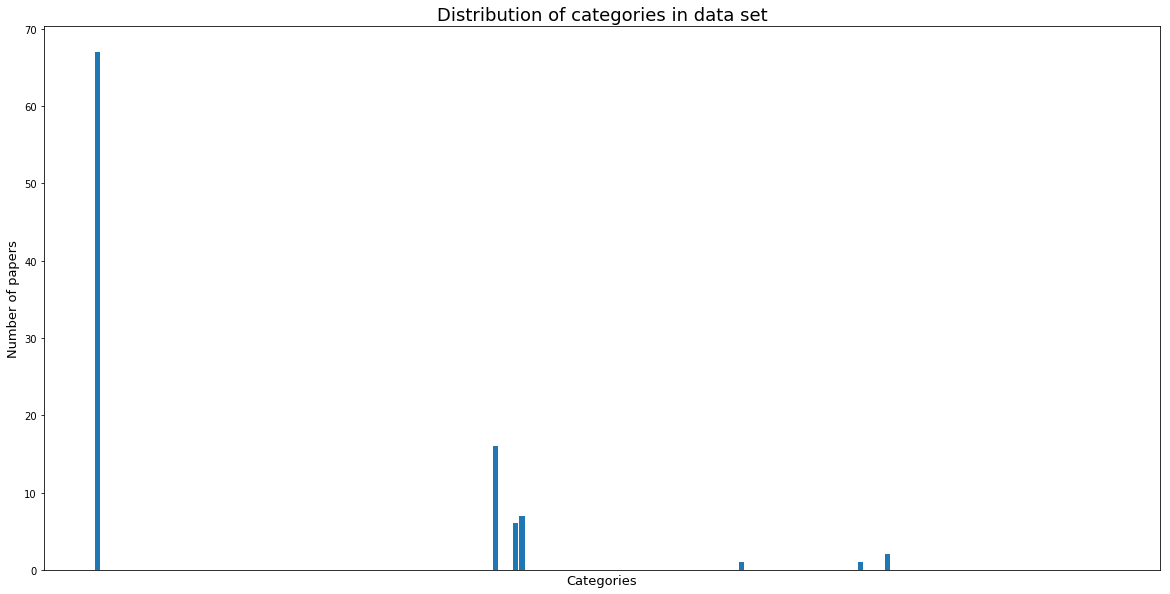

In [8]:
# find the amount of papers in each category
sum_df = cat_df.apply(lambda x: x.sum())

# plot the distribution of the amount of papers in each category
plt.figure(figsize=(20,10))
plt.bar(x=sum_df.keys(), height=sum_df.values)
plt.xlabel('Categories', fontsize=13)
plt.ylabel('Number of papers', fontsize=13)
plt.title('Distribution of categories in data set', fontsize=18)
plt.xticks([])
plt.show()

<h2> ELMo feature extraction </h2>

To build our model we have to extract features from the titles and abstracts. We will be using ELMo, a state-of-the-art NLP framework developed by AllenNLP, which converts text input into vectors, with similar words being closer to each other. We will need the following extra packages.

In [9]:
import tensorflow_hub as hub
import tensorflow as tf
import pickle

W0426 17:36:04.818202 139711887521600 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Next, we download the ELMo model. It is over 350mb in size, so it might take a little while.

In [10]:
# download the ELMo model
#!mkdir elmo
#!curl -L "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed" | tar -zxvC elmo

# load the ELMo model
elmo_model = hub.Module("elmo", trainable=False)
print("ELMo model set up!")

W0426 17:36:05.305238 139711887521600 deprecation.py:323] From /home/leidem/.local/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


ELMo model set up!


In [11]:
def elmo_vectors(x):
    embeddings = elmo_model(x.tolist(), signature="default", as_dict=True)["elmo"]

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        
        # return average of ELMo features
        return sess.run(tf.reduce_mean(embeddings,1))

In [12]:
# build ELMo data
batch_size = 10
batches = [df[i:i+batch_size]['title'] for i in range(0, df.shape[0], batch_size)]
elmo_batches = [elmo_vectors(batch) for batch in batches]
elmo_data = np.concatenate(elmo_batches, axis = 0)

# save ELMo data
with open("elmo_data_test.pickle","wb") as pickle_out:
    pickle.dump(elmo_data, pickle_out)

In [13]:
# load ELMo data
pickle_in = open("elmo_data_test.pickle", "rb")
elmo_data = pickle.load(pickle_in)

print("ELMo data loaded!")

ELMo data loaded!


<h2> Building the model </h2>

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [15]:
Y_test = []
Y_hat = []
for i, cat in enumerate(cats):
        
    X_train, X_test, y_train, y_test = train_test_split(elmo_data, df[cat], random_state=4, test_size=0.2)
    
    Y_test.append(y_test)
    
    try:
        lreg = LogisticRegression(C=0.0001, solver='liblinear')
        lreg.fit(X_train, y_train)
        Y_hat.append(lreg.predict(X_test))
    except:
        Y_hat.append(np.array([0] * len(y_test)))

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 

<h2> Testing the model </h2>

In [16]:
from sklearn.metrics import f1_score
from statistics import mean

In [17]:
f1s = [f1_score(x, y) for (x,y) in zip(Y_test, Y_hat)]

print(f"The highest f1 score for the model is {max(f1s)}.")
print(f"The average f1 score for the model is {mean(f1s)}.")

The highest f1 score for the model is 0.8571428571428571.
The average f1 score for the model is 0.0056022408963585435.


/home/leidem/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
